# Geo Data

In this code we are going to both process the geo data and define a function so that, given a point, we see the projects that are the closest to it.

## Importing data

In [1]:

import geopandas
import pandas as pd
from shapely.geometry import Point, LineString, Polygon
path = r"C:\Users\lluis\OneDrive\Documentos\ETH\H4G\git\wwf\data\geodata\Hochmoor_LV03\hochmoor.shp"
path_to_data = path
gdf = geopandas.read_file(path_to_data)
gdf.head(5)

ObjNummer                                    Name  \
0         1  La Sagne et les Tourbières de Bellelay   
1         1  La Sagne et les Tourbières de Bellelay   
2         1  La Sagne et les Tourbières de Bellelay   
3         1  La Sagne et les Tourbières de Bellelay   
4         1  La Sagne et les Tourbières de Bellelay   

                                          RefObjBlat DesignatTy IUCNCatego  \
0  https://data.geo.admin.ch/ch.bafu.bundesinvent...        NDA         Ia   
1  https://data.geo.admin.ch/ch.bafu.bundesinvent...        NDA         Ia   
2  https://data.geo.admin.ch/ch.bafu.bundesinvent...        NDA         Ia   
3  https://data.geo.admin.ch/ch.bafu.bundesinvent...        NDA         Ia   
4  https://data.geo.admin.ch/ch.bafu.bundesinvent...        NDA         Ia   

   Inkraftset Mutationsd Mutationsg  Typ  Einheit  HM_KE  TeilObjNum  \
0  1991-02-01       None       None    3        7      7           1   
1  1991-02-01       None       None    3        7      7           1   
2  1991-02-01       None       None    2        4     24           1   
3  1991-02-01       None       None    3        7      7           3   
4  1991-02-01       None       None    2        5     25           1   

    Shape_Leng     Shape_Area  \
0  3405.612863   82558.104397   
1  1618.332553   25360.715029   
2   146.469805     861.118734   
3   995.794465   58232.517841   
4  3137.075334  138578.514622   

                                            geometry  
0  POLYGON ((579136.128 233933.093, 579140.628 23...  
1  POLYGON ((580137.500 233841.297, 580144.813 23...  
2  POLYGON ((579755.691 233876.799, 579752.316 23...  
3  POLYGON ((580334.812 233851.594, 580317.125 23...  
4  POLYGON ((579745.129 233971.798, 579755.628 23...

In [26]:
gdf = gdf.to_crs('epsg:4326', epsg = 'epsg:21781') #Going from Swiss to Longitude Latitude coords

In [27]:
gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [2]:
gdf.iloc[0]['RefObjBlat']

'https://data.geo.admin.ch/ch.bafu.bundesinventare-hochmoore/objectsheets/2017revision/nr1.pdf'

## Understanding the data

The data is like a pandas but with a final column called "geometry", where it outputs the polygon that the row represents.
\
The main features to take into account are: \
* ObjNummer: It refers to a particular zone in potential danger.
* RefObjBlat: The pdf that explains everything about the zone.
* Type: Each polygon of the zone can be of one out of six types, depending on the level of danger.
* Geometry: Plots the polygon

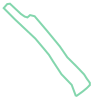

In [3]:
gdf.iloc[512]["geometry"].boundary

In [30]:
gdf.iloc[512]["RefObjBlat"]

'https://data.geo.admin.ch/ch.bafu.bundesinventare-hochmoore/objectsheets/2017revision/nr15.pdf'

Useful functions: centroid computes the centroid of the polygon, boundary gets the boundary and distance computes the distance between points.

In [31]:
gdf.centroid

C:\Users\lluis\AppData\Local\Temp\ipykernel_31044\2017122361.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf.centroid


0       POINT (7.16620 47.25596)
1       POINT (7.17723 47.25394)
2       POINT (7.17129 47.25580)
3       POINT (7.17683 47.25644)
4       POINT (7.17163 47.25492)
                  ...           
8200    POINT (8.02703 46.39013)
8201    POINT (8.02739 46.39052)
8202    POINT (8.02399 46.38881)
8203    POINT (8.02836 46.39082)
8204    POINT (8.02498 46.38937)
Length: 8205, dtype: geometry

Geopandas has a polygon of the form POLYGON((Y1 X1, Y2 X2, ...)). Apparently the values represent the coordinates of the vertices of the polygon in the Swiss system. Therefore we have to access to the coordinates -> Convert them into standard latitude longitude -> Define a function to calculate the distance between a point and the polygon

Some previous tests:

In [32]:
ObjNummer15 = gdf[gdf["ObjNummer"]==gdf.iloc[512]["ObjNummer"]]

In [33]:
for i, row in ObjNummer15.iterrows():
    ObjNummer15["geometry"].iloc[0]

In [34]:
ObjNummer15 = ObjNummer15.reset_index(drop=True)

In [35]:
type1 = ObjNummer15[ObjNummer15["Typ"]==1]
type1.shape

(19, 15)

In [36]:
type2 = ObjNummer15[ObjNummer15["Typ"]==2]
type2.shape

(643, 15)

In [37]:
type3 = ObjNummer15[ObjNummer15["Typ"]==3]
type3.shape

(522, 15)

In [38]:
type4 = ObjNummer15[ObjNummer15["Typ"]==4]
type4.shape

(67, 15)

<AxesSubplot: >

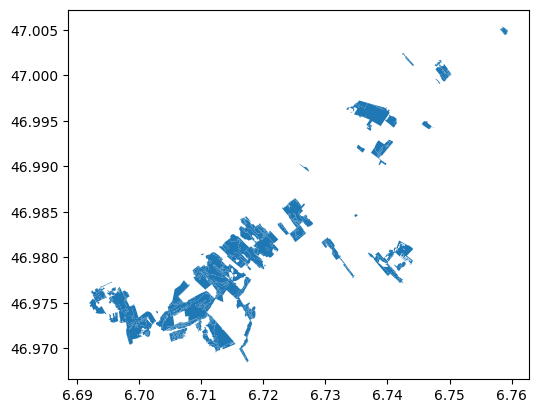

In [39]:
ObjNummer15[ObjNummer15["Typ"]==2]["geometry"].plot()

SUMMING UP FINDINGS:
\
Each objectnumber corresponds to a particular forest. Each row has a polygon within the forest.
\
Typ column means the type of zone that polygon represents:


Goal now: Calculate distances
\
\
First let's convert it into latitude longitude

In [40]:
polygon = gdf.iloc[512]["geometry"].boundary

In [41]:
from pyproj import Proj, Transformer, transform
from shapely.geometry import Point

def changeofcoordinates(point):
    pWorld = Proj(init='epsg:4326')
    pCH = Proj(init='epsg:21781')
    newpoint = transform(pCH,pWorld, point.coords[0][0], point.coords[0][1],always_xy=True) #IN GOOGLE MAPS YOU PUT THE INVERSE ORDER!!!!!!!
    return Point(newpoint[0], newpoint[1])
def changeofcoordinatestuple(tuple):
    pWorld = Proj(init='epsg:4326')
    pCH = Proj(init='epsg:21781')
    newpoint = transform(pCH,pWorld, tuple[0], tuple[1],always_xy=True) #IN GOOGLE MAPS YOU PUT THE INVERSE ORDER!!!!!!!
    return Point(newpoint[0], newpoint[1])
#Google maps format: latitude, longitude


Compute efficiently the distance of a given point to the boundary

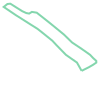

In [42]:
polygon

Let's try to reduce the number of boundary points

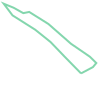

In [43]:
newcoords = []
i=0
while i<len(polygon.coords[0:]):
    newcoords.append(polygon.coords[i])
    i+=int(len(polygon.coords[0:])/10)
newboundary = LineString(newcoords)
newboundary

In [44]:
def boundaryreduction(boundary):
    newcoords = []
    i=0
    while i<len(boundary.coords[0:]):
        newcoords.append(boundary.coords[i])
        i+=int(len(boundary.coords[0:])/10)
    newboundary = LineString(newcoords)
    return newboundary

In [45]:
from numpy import infty

def distance(point, boundaries, reducedimensionality=False):
    min = infty
    for boundary in boundaries:
        if reducedimensionality==True:
            boundary = boundaryreduction(boundary)
        dist = boundary.distance(point)
        if min > dist:
            min = dist
        
    return min
            


There are 941 different forests / non-touchable places

In [53]:
#pipeline

def Nclosest(point, gdf, N=1, reducedimensionality=False, typesinrisk = [1]):
    i = 1
    ordereddistances = [infty]*(N+1)
    keys = [0]*(N+1)
    while i <= 941:
        print(f'Object number = {i}')
        dataset = gdf[gdf["ObjNummer"]==str(i)].reset_index(drop = True)
        dataset = dataset[dataset["Typ"].isin([1,2,3,4,5,6])].reset_index(drop=True)
        print(dataset.shape)
        dista = distance(point, dataset["geometry"].boundary, reducedimensionality = False)
        print(dista)
        j = 0
        while j < N:
            if ordereddistances[N-j-1]>dista:
                ordereddistances[N-j] = ordereddistances[N-j-1]
                ordereddistances[N-j-1] = dista
                keys[N-j] = keys[N-j-1]
                keys[N-j-1] = i
                j+=1
            else: break
        i+=1
    
    return ordereddistances[:-1], keys[:-1]

        
        

Check if it works:

In [54]:
checkpoint =Point(7.16299,47.25597)

In [55]:
Nclosest(checkpoint, gdf, N=3, reducedimensionality=True, typesinrisk = [1,2,3,4,5,6])

Object number = 1
(27, 15)
2.373118633251377e-06
Object number = 2
(29, 15)
0.10204449064882205
Object number = 3
(23, 15)
0.10963069465404304
Object number = 4
(5, 15)
0.06347010395372357
Object number = 5
(9, 15)
0.04188583654038794
Object number = 6
(19, 15)
0.07190245061356534
Object number = 7
(12, 15)
0.12338181010254808
Object number = 8
(17, 15)
0.0907878599071677
Object number = 9
(12, 15)
0.2068814077642268
Object number = 10
(17, 15)
0.22352774333660466
Object number = 11
(17, 15)
0.19902839320719642
Object number = 12
(31, 15)
0.5596202720872802
Object number = 13
(156, 15)
0.5765481659989512
Object number = 14
(2, 15)
0.5396422377925676
Object number = 15
(1272, 15)
0.475266458291048
Object number = 16
(296, 15)
0.5437626957707385
Object number = 17
(156, 15)
0.5899846834882273
Object number = 18
(129, 15)
0.6381675945847805
Object number = 19
(36, 15)
0.2387371395906782
Object number = 20
(42, 15)
0.4299811231341865
Object number = 21
(6, 15)
0.22877586293898036
Object nu

([2.373118633251377e-06, 0.023518061391024532, 0.026969297619504107],
 [1, 605, 41])

ObjNummer                                    Name  \
0            1  La Sagne et les Tourbières de Bellelay   
1            1  La Sagne et les Tourbières de Bellelay   
2            1  La Sagne et les Tourbières de Bellelay   
3            1  La Sagne et les Tourbières de Bellelay   
4            1  La Sagne et les Tourbières de Bellelay   
...        ...                                     ...   
8200       941                             Aletschwald   
8201       941                             Aletschwald   
8202       941                             Aletschwald   
8203       941                             Aletschwald   
8204       941                             Aletschwald   

                                             RefObjBlat DesignatTy IUCNCatego  \
0     https://data.geo.admin.ch/ch.bafu.bundesinvent...        NDA         Ia   
1     https://data.geo.admin.ch/ch.bafu.bundesinvent...        NDA         Ia   
2     https://data.geo.admin.ch/ch.bafu.bundesinvent...        NDA         Ia   
3     https://data.geo.admin.ch/ch.bafu.bundesinvent...        NDA         Ia   
4     https://data.geo.admin.ch/ch.bafu.bundesinvent...        NDA         Ia   
...                                                 ...        ...        ...   
8200  https://data.geo.admin.ch/ch.bafu.bundesinvent...        NDA         Ia   
8201  https://data.geo.admin.ch/ch.bafu.bundesinvent...        NDA         Ia   
8202  https://data.geo.admin.ch/ch.bafu.bundesinvent...        NDA         Ia   
8203  https://data.geo.admin.ch/ch.bafu.bundesinvent...        NDA         Ia   
8204  https://data.geo.admin.ch/ch.bafu.bundesinvent...        NDA         Ia   

      Inkraftset Mutationsd Mutationsg  Typ  Einheit  HM_KE  TeilObjNum  \
0     1991-02-01       None       None    3        7      7           1   
1     1991-02-01       None       None    3        7      7           1   
2     1991-02-01       None       None    2        4     24           1   
3     1991-02-01       None       None    3        7      7           3   
4     1991-02-01       None       None    2        5     25           1   
...          ...        ...        ...  ...      ...    ...         ...   
8200  1991-02-01       None       None    1        6      6           1   
8201  1991-02-01       None       None    3        9      9           1   
8202  1991-02-01       None       None    1        6      6           1   
8203  1991-02-01       None       None    3       18     18           1   
8204  1991-02-01       None       None    1        6      6           1   

       Shape_Leng     Shape_Area  \
0     3405.612863   82558.104397   
1     1618.332553   25360.715029   
2      146.469805     861.118734   
3      995.794465   58232.517841   
4     3137.075334  138578.514622   
...           ...            ...   
8200   308.666869    2862.666551   
8201   143.638886    1262.726812   
8202    97.966808     445.935988   
8203   536.060821    4852.380052   
8204   149.006778    1393.238014   

                                               geometry  
0     POLYGON ((7.16299 47.25597, 7.16305 47.25599, ...  
1     POLYGON ((7.17622 47.25518, 7.17632 47.25512, ...  
2     POLYGON ((7.17118 47.25549, 7.17113 47.25560, ...  
3     POLYGON ((7.17883 47.25528, 7.17860 47.25528, ...  
4     POLYGON ((7.17103 47.25634, 7.17117 47.25631, ...  
...                                                 ...  
8200  POLYGON ((8.02755 46.39037, 8.02757 46.39040, ...  
8201  POLYGON ((8.02763 46.39076, 8.02762 46.39070, ...  
8202  POLYGON ((8.02375 46.38867, 8.02377 46.38872, ...  
8203  POLYGON ((8.02763 46.39076, 8.02765 46.39079, ...  
8204  POLYGON ((8.02471 46.38921, 8.02467 46.38922, ...  

[8205 rows x 15 columns]